# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# DISTRIBUIÇÃO DO DDPG
# MODIFICAR O GENÉTICO PARA MAIOR DIVERSIFICAÇÃO

# Dados

In [ ]:
start_date = '2023-01-01'
end_date = '2024-01-01'
initial_value = 100000

adj_close_df = pd.read_csv('relatorios/preco-ativos.csv', index_col=0, parse_dates=True)
daily_return = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
df_selic = pd.read_csv('baselines/SELIC.csv', index_col=0, parse_dates=True, sep=';', dayfirst=True)

rebalance_dates = pd.DatetimeIndex(pd.read_csv('relatorios/datas-fim-de-mes.txt', header=None)[0])
rebalance_dates = rebalance_dates[(rebalance_dates>=start_date) & (rebalance_dates <= end_date)]

# Modelo

In [3]:
portfolio_value = initial_value
portfolio_values = []
dates = []
weights_history = []

# Modelo
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, **kwargs):
        super().__init__(n_var=len(mu), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
    def _evaluate(self, x, out, *args, **kwargs):
        expected_return = self.mu.T @ x
        risk = x.T @ self.cov @ x
        out["F"] = [risk, -expected_return]

class SumToOneRepair(Repair):
    def _do(self, problem, X, **kwargs):
        return X / np.sum(X, axis=1, keepdims=True)

for i in range(len(rebalance_dates)-1):
    # Selecionar dados até o rebalanceamento atual
    period_start = rebalance_dates[i]
    period_end = rebalance_dates[i+1]
    log_returns = daily_return.loc[:period_start].iloc[-252:]
    if log_returns.empty:
        continue
    mu = log_returns.mean() * 252
    cov = log_returns.cov() * 252

    # Obter a taxa livre de risco do DataFrame SELIC
    if period_start in df_selic.index:
        risk_free_rate = df_selic.loc[period_start, 'Taxa'] / 100  # Converter de % para decimal
    else:
        risk_free_rate = 0.02  # Valor padrão caso a data não esteja no DataFrame

    # Otimizar portfólio
    problem = PortfolioProblem(mu, cov)
    algorithm = NSGA2(pop_size=100,
                      repair=SumToOneRepair(),
                      crossover=SBX(prob=0.9, eta=20.0),
                      mutation=PM(prob=1.0 / problem.n_var,eta=20.0))
    termination = get_termination("n_gen", 500)
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   verbose=False)
    
    sharpe_ratios = (res.F[:, 1]*-1 - risk_free_rate) / np.sqrt(res.F[:, 0])
    weights = res.X[np.argmax(sharpe_ratios)]

    weights_history.append(weights)
    dates.append(period_start)

    # Calcular retorno do portfólio no mês seguinte
    next_period_prices = adj_close_df.loc[[period_start,period_end]]
    next_simple_returns = next_period_prices.pct_change().dropna()
    monthly_returns = next_simple_returns @ weights
    portfolio_return = monthly_returns.sum()
    portfolio_value *= (1 + portfolio_return)
    portfolio_values.append(portfolio_value)

# Calcular métricas finais
portfolio_values = np.array(portfolio_values)
total_return = portfolio_value / initial_value - 1
n_years = (rebalance_dates[-1] - rebalance_dates[0]).days / 365
annualized_return = (portfolio_value / initial_value) ** (1/n_years) - 1
log_portfolio_returns = np.log(portfolio_values[1:] / portfolio_values[:-1])
annualized_volatility = log_portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_return - 0.02) / annualized_volatility

# Maximum Drawdown
cum_values = pd.Series(portfolio_values, index=dates[:len(portfolio_values)])
peak = cum_values.cummax()
drawdown = (cum_values - peak) / peak
max_drawdown = drawdown.min()

print(f"Retorno anualizado: {annualized_return:.2%}")
print(f"Volatilidade anualizada: {annualized_volatility:.2%}")
print(f"Índice de Sharpe: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Valor final do portfólio: ${portfolio_value:.2f}")

Retorno anualizado: -12.54%
Volatilidade anualizada: 10.78%
Índice de Sharpe: -1.35
Maximum Drawdown: -9.65%
Valor final do portfólio: $88558.75


# Análise dos resultados

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Valor ($)')

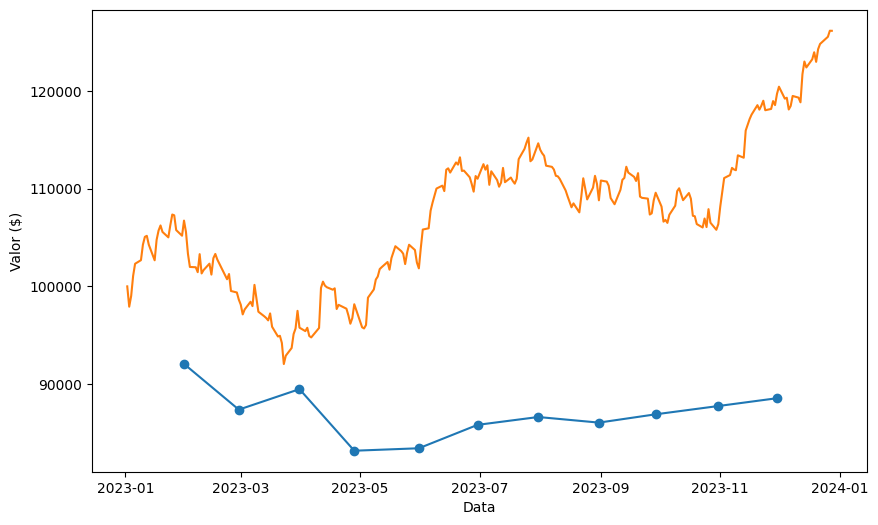

In [4]:
import matplotlib.pyplot as plt
# Baixar dados do IBOVESPA (índice B3)
ibov_data = yf.download('^BVSP', start='2023-01-01', end='2024-01-01', auto_adjust=False)
ibov_prices = ibov_data['Adj Close']

# Calcular evolução do valor investido no IBOVESPA (mesma lógica, inicial 10k)
ibov_values = [initial_value]
for i in range(1, len(ibov_prices)):
    ret = ibov_prices.iloc[i] / ibov_prices.iloc[i-1] - 1
    if isinstance(ret, pd.Series):
        ret = ret.values[0]
    ibov_values.append(ibov_values[-1] * (1 + float(ret)))
ibov_values = np.array(ibov_values)

# Ajustar datas para o mesmo eixo do portfólio
ibov_plot_dates = ibov_prices.index

plt.figure(figsize=(10, 6))
plt.plot(dates[:len(portfolio_values)], portfolio_values, marker='o', label='Portfólio NSGA-II')
plt.plot(ibov_plot_dates, ibov_values, label='IBOVESPA - $10k inicial')
plt.xlabel('Data')
plt.ylabel('Valor ($)')

In [5]:
# Ler o arquivo IMA-GERAL.xls
ima_geral_file = 'baselines/IMA-GERAL.xls'  # ou o caminho completo do arquivo
start_date = '2023-01-01'
end_date = '2023-11-30'
try:
    df_ima_geral = pd.read_excel(ima_geral_file, 
                                usecols=['Data de Referência', 'Número Índice'],
                                decimal=',',
                                thousands='.')
    
    # Processar dados
    df_ima_geral['Date'] = pd.to_datetime(df_ima_geral['Data de Referência'], dayfirst=True)
    df_ima_geral['IMA_GERAL'] = pd.to_numeric(df_ima_geral['Número Índice'])
    
    # Filtrar período se necessário
    if 'start_date' in locals() and 'end_date' in locals():
        df_ima_geral_periodo = df_ima_geral.query("Date >= @start_date and Date <= @end_date").copy()
    else:
        df_ima_geral_periodo = df_ima_geral.copy()

    df_ima_geral_periodo = df_ima_geral_periodo[['Date', 'IMA_GERAL']]
    
    print("Dados do IMA-GERAL carregados com sucesso!")
    print(f"Período: {df_ima_geral_periodo['Date'].min()} a {df_ima_geral_periodo['Date'].max()}")
    print(f"Número de observações: {len(df_ima_geral_periodo)}")
    print("\nPrimeiras linhas:")
    print(df_ima_geral_periodo[['Date', 'IMA_GERAL']].head())
    
except FileNotFoundError:
    print(f"Arquivo {ima_geral_file} não encontrado!")
except Exception as e:
    print(f"Erro ao ler o arquivo: {e}")

/home/yoshiyuki/Documents/tcc-code/venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Dados do IMA-GERAL carregados com sucesso!
Período: 2023-01-02 00:00:00 a 2023-11-30 00:00:00
Número de observações: 229

Primeiras linhas:
           Date    IMA_GERAL
5289 2023-01-02  6907.103938
5290 2023-01-03  6891.723623
5291 2023-01-04  6885.242491
5292 2023-01-05  6899.419899
5293 2023-01-06  6915.835050


In [6]:
# Calcular métricas do IBOVESPA
ibov_total_return = (ibov_values[-1] / ibov_values[0]) - 1
ibov_final_value = ibov_values[-1]

print(f"=== RESULTADOS IBOVESPA ===")
print(f"Valor inicial: ${initial_value:,.2f}")
print(f"Valor final: ${ibov_final_value:,.2f}")
print(f"Retorno total: {ibov_total_return:.2%}")

# Comparação com o portfólio NSGA-II
print(f"\n=== COMPARAÇÃO ===")
print(f"Portfólio NSGA-II: ${portfolio_value:,.2f} ({total_return:.2%})")
print(f"IBOVESPA: ${ibov_final_value:,.2f} ({ibov_total_return:.2%})")
print(f"Diferença: ${portfolio_value - ibov_final_value:,.2f}")

=== RESULTADOS IBOVESPA ===
Valor inicial: $100,000.00
Valor final: $126,142.17
Retorno total: 26.14%

=== COMPARAÇÃO ===
Portfólio NSGA-II: $88,558.75 (-11.44%)
IBOVESPA: $126,142.17 (26.14%)
Diferença: $-37,583.42



=== RESULTADOS IMA-GERAL ===
Valor inicial: R$ 100,000.00
Valor final: R$ 113,252.64
Retorno total: 13.25%


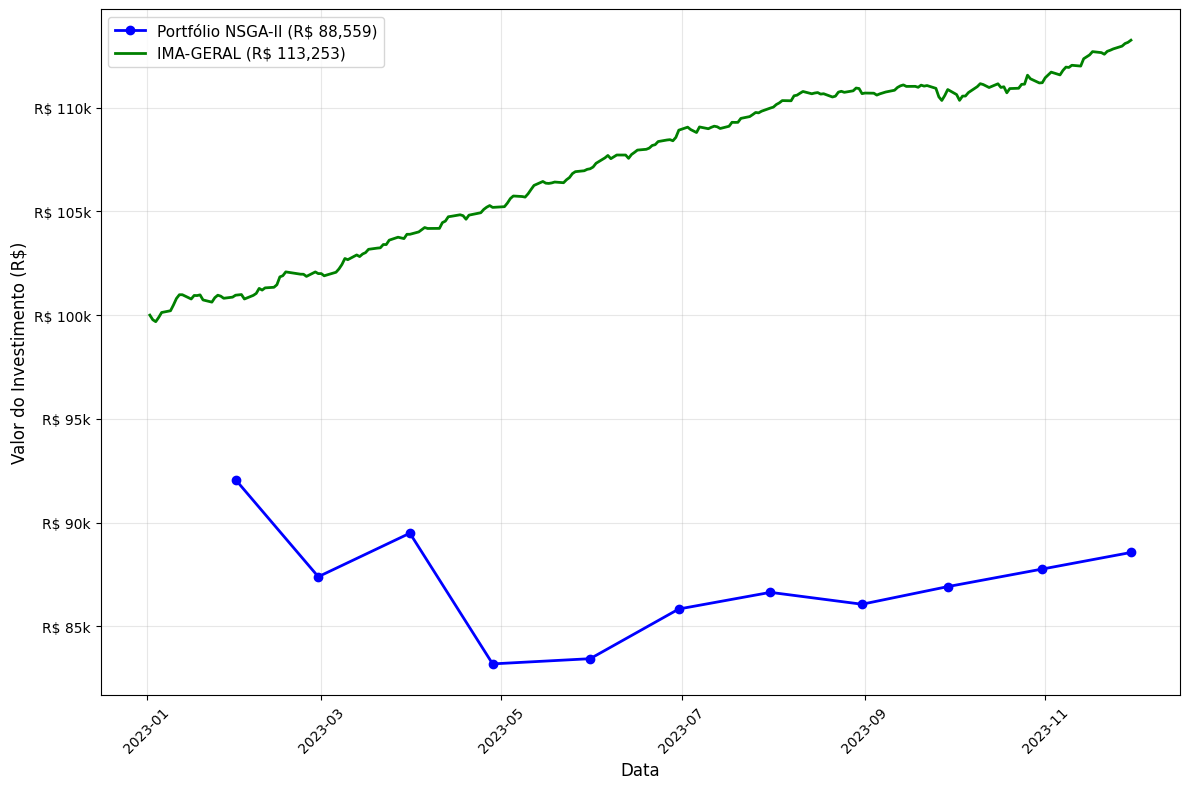


=== TABELA COMPARATIVA ===
Estratégia Valor Final (R$) Retorno Total
   NSGA-II        88,558.75       -11.44%
 IMA-GERAL       113,252.64        13.25%
  IBOVESPA       126,142.17        26.14%


In [7]:
# Calcular evolução do valor investido no IMA-GERAL
def calculate_ima_performance(df_ima, initial_value):
    # Ordenar por data para garantir sequência correta
    df_sorted = df_ima.sort_values('Date').copy()
    
    # Resetar index para facilitar iteração
    df_sorted = df_sorted.reset_index(drop=True)
    
    # Calcular retornos do IMA-GERAL
    df_sorted['Returns'] = df_sorted['IMA_GERAL'].pct_change()
    
    # Calcular evolução do valor do investimento
    ima_values = [initial_value]
    ima_dates = [df_sorted['Date'].iloc[0]]
    
    for i in range(1, len(df_sorted)):
        ret = df_sorted['Returns'].iloc[i]
        if pd.notna(ret):
            new_value = ima_values[-1] * (1 + ret)
        else:
            new_value = ima_values[-1]
        
        ima_values.append(new_value)
        ima_dates.append(df_sorted['Date'].iloc[i])
    
    return np.array(ima_values), pd.to_datetime(ima_dates)

# Calcular performance do IMA-GERAL se os dados foram carregados
if 'df_ima_geral_periodo' in locals() and len(df_ima_geral_periodo) > 0:
    ima_values, ima_dates = calculate_ima_performance(df_ima_geral_periodo, initial_value)
    
    # Calcular métricas do IMA-GERAL
    ima_total_return = (ima_values[-1] / initial_value) - 1
    ima_final_value = ima_values[-1]
    
    print(f"\n=== RESULTADOS IMA-GERAL ===")
    print(f"Valor inicial: R$ {initial_value:,.2f}")
    print(f"Valor final: R$ {ima_final_value:,.2f}")
    print(f"Retorno total: {ima_total_return:.2%}")
    
    # Gráfico comparativo
    plt.figure(figsize=(12, 8))
    
    # Plotar portfólio NSGA-II
    plt.plot(dates[:len(portfolio_values)], portfolio_values, marker='o', linewidth=2, 
             label=f'Portfólio NSGA-II (R$ {portfolio_value:,.0f})', color='blue')
    
    # Plotar IBOVESPA
    #if 'ibov_values' in locals():
    #    plt.plot(ibov_plot_dates, ibov_values, linewidth=2, 
    #             label=f'IBOVESPA (R$ {ibov_values[-1]:,.0f})', color='red')
    
    # Plotar IMA-GERAL
    plt.plot(ima_dates, ima_values, linewidth=2, 
             label=f'IMA-GERAL (R$ {ima_final_value:,.0f})', color='green')
    
    # Personalização do gráfico
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Valor do Investimento (R$)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Formatação do eixo Y
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}k'))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Tabela comparativa
    comparison_data = {
        'Estratégia': ['NSGA-II', 'IMA-GERAL'],
        'Valor Final (R$)': [f"{portfolio_value:,.2f}", f"{ima_final_value:,.2f}"],
        'Retorno Total': [f"{total_return:.2%}", f"{ima_total_return:.2%}"]
    }
    
    if 'ibov_values' in locals():
        ibov_total_return = (ibov_values[-1] / initial_value) - 1
        comparison_data['Estratégia'].append('IBOVESPA')
        comparison_data['Valor Final (R$)'].append(f"{ibov_values[-1]:,.2f}")
        comparison_data['Retorno Total'].append(f"{ibov_total_return:.2%}")
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n=== TABELA COMPARATIVA ===")
    print(comparison_df.to_string(index=False))
    
else:
    print("Dados do IMA-GERAL não foram carregados ou estão vazios.")

In [8]:
# Criar uma lista com os tickers dos ativos
tickers = adj_close_df.columns.tolist()

# Criar um DataFrame para armazenar a composição do portfólio e o valor do portfólio
portfolio_composition = pd.DataFrame(weights_history, columns=tickers, index=dates)
portfolio_composition['Portfolio Value'] = portfolio_values

# Adicionar uma coluna com os pesos em porcentagem
portfolio_composition_percent = portfolio_composition.iloc[:, :-1] * 100

# Exibir a composição do portfólio ao final de cada mês
print("Composição do portfólio ao final de cada mês:")
print(portfolio_composition_percent)

# Selecionar a composição de um mês específico
selected_date = dates[-1]  # Exemplo: última data de rebalanceamento
selected_composition = portfolio_composition_percent.loc[selected_date]

print(f"\nComposição do portfólio em {selected_date.strftime('%Y-%m-%d')}:")
print(selected_composition)

# Exibir o valor do portfólio na data selecionada
portfolio_value_at_date = portfolio_composition.loc[selected_date, 'Portfolio Value']
print(f"\nValor do portfólio em {selected_date.strftime('%Y-%m-%d')}: ${portfolio_value_at_date:.2f}")

Composição do portfólio ao final de cada mês:
               ABEV3     B3SA3     BBAS3     BBDC4      BBSE3    BPAC11  \
2023-01-31  0.000395  0.001530  0.008864  0.002193  78.423574  0.001204   
2023-02-28  0.002088  0.000018  0.000045  0.000729  93.490771  0.000063   
2023-03-31  0.000254  0.001918  0.000934  0.002153  73.756550  0.002239   
2023-04-28  0.002507  0.000460  0.048028  0.000684  65.198117  0.003358   
2023-05-31  0.003002  0.008413  0.027293  0.002108  31.849453  0.000866   
2023-06-30  0.028885  0.020724  6.699187  0.002262   0.256783  0.076721   
2023-07-31  0.000315  0.030574  0.149672  0.011935   0.013422  0.096759   
2023-08-31  0.006804  0.017346  0.089687  0.024092   0.036219  0.007305   
2023-09-29  0.002405  0.009443  0.025610  0.003167   0.106943  0.075379   
2023-10-31  0.002008  0.018640  0.019712  0.001706   0.004818  0.012688   
2023-11-30  0.007432  0.000801  0.031049  0.008393   0.016329  0.013770   

               ELET3      EMBR3     ENEV3      EQTL3 